# **AlphaFold 3 Score Visualizer**

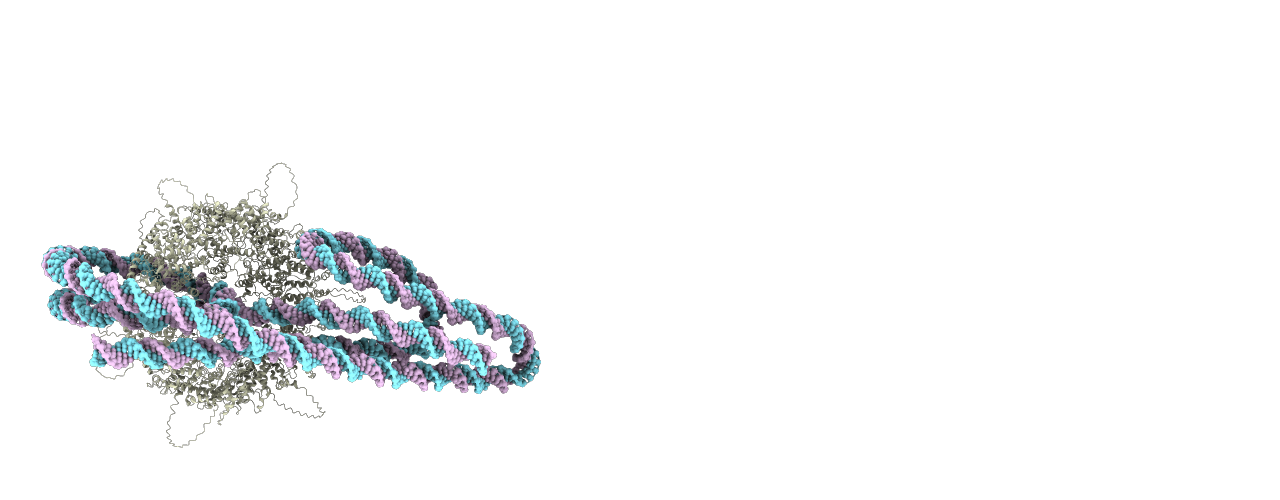
*Figure 1: "This is amazing!" - Jens*

This notebook provides a simple overview of all confidence measures in an AlphaFold 3 prediction.

In [2]:
#@title # **Step 1: Mount your Google Drive 🏇**
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Note:** Run the cell above ▶ to access the AlphaFold 3 predictions you have in your Google Drive storage 🌥. Mounting your Google Drive is recommended, because uploading your files to colab takes a while.

In [3]:
#@title # **Step 2: Specify a path to your output folder and chose a model 🔍**
import re
import os
import ipywidgets as widgets
from IPython.display import display, HTML, Markdown

# Define global variables to store analysis output
iptm_matrix_heatmap_image = None
pae_heatmap_image = None
contact_probs_heatmap_image = None

# Define global variables to reference analysis folder paths
iptm_matrix_heatmap_folder = None
pae_heatmap_folder = None
contact_probs_heatmap_folder = None

# Define global variables to store selected file paths
selected_folder_path = None
selected_full_data_file_path = None
selected_summary_confidences_file_path = None
selected_integer_ending = None
selected_model_file_path = None

# Step 1: Allow User to Specify Folder Path
display(Markdown('Folder path:'))
folder_path_textbox = widgets.Text(value='', placeholder='Enter folder path')
folder_path_textbox.layout.width = 'auto'
display(folder_path_textbox)

# Step 2: Scan the Folder and Filter Files
def scan_and_filter_files(folder_path):
    try:
        files_in_folder = os.listdir(folder_path)

        # Define regex pattern for matching file names
        file_pattern = re.compile(r'(.+?)_(\d+)\.(.+)$')

        # Filter files based on regex pattern
        files = {}
        for file_name in files_in_folder:
            match = file_pattern.match(file_name)
            if match:
                prefix, integer, suffix = match.groups()
                if integer not in files:
                    files[integer] = {}
                files[integer][prefix] = os.path.join(folder_path, file_name)

        return files

    except FileNotFoundError:
        print("Specified folder path does not exist. Please enter a valid folder path.")
        return {}

# Step 3: Create Dropdown Widget for Selecting Integer Endings
display(Markdown('Select a model number:'))
integer_ending_dropdown = widgets.Dropdown(options=[])
# Set the style of the dropdown to increase width
integer_ending_dropdown.layout.width = 'auto'

# Define function to update dropdown options when folder path changes
def update_dropdown_options(change):
    global selected_folder_path
    selected_folder_path = change.new

    files = scan_and_filter_files(selected_folder_path)
    integer_endings = set(files.keys())

    integer_ending_dropdown.options = sorted(list(integer_endings))

# Link folder path textbox value to update_dropdown_options function
folder_path_textbox.observe(update_dropdown_options, names='value')

# Display the dropdown widget for selecting integer endings
display(integer_ending_dropdown)

# Step 4: Access the Selected Files
def on_integer_ending_change(change):
    global selected_full_data_file_path
    global selected_summary_confidences_file_path
    global selected_model_file_path
    global selected_integer_ending

    selected_integer_ending = change.new

    if selected_integer_ending is not None:
        files = scan_and_filter_files(selected_folder_path)
        if selected_integer_ending in files:
            selected_files = files[selected_integer_ending]

            # Define regex patterns for full_data and summary_confidences files
            full_data_pattern = re.compile(r'.*full_data$')
            summary_confidences_pattern = re.compile(r'.*summary_confidences$')
            model_pattern = re.compile(r'.*model$')

            selected_full_data_file_path = None
            selected_summary_confidences_file_path = None
            selected_model_file_path = None

            for file_name, file_path in selected_files.items():

                full_data_match = full_data_pattern.match(file_name)
                summary_confidences_match = summary_confidences_pattern.match(file_name)
                model_match = model_pattern.match(file_name)

                if full_data_match:
                    selected_full_data_file_path = file_path
                elif summary_confidences_match:
                    selected_summary_confidences_file_path = file_path
                elif model_match:
                    selected_model_file_path = file_path

            if selected_full_data_file_path and selected_summary_confidences_file_path and selected_model_file_path:
                print("Selected full_data file path:", selected_full_data_file_path)
                print("Selected summary_confidences file path:", selected_summary_confidences_file_path)
                print("Selected model file path:", selected_model_file_path)
            else:
                print("Some files are missing for the selected integer model number.")
        else:
            print("No files found for the selected integer model number.")
    else:
        print("Please select an integer model number.")


# Link dropdown to the function to update selected file paths
integer_ending_dropdown.observe(on_integer_ending_change, names='value')

Folder path:

Text(value='', layout=Layout(width='auto'), placeholder='Enter folder path')

Select a model number:

Dropdown(layout=Layout(width='auto'), options=(), value=None)

Selected full_data file path: /content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /akap240_fap65_seed-1_sample-full_data_0.json
Selected summary_confidences file path: /content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /akap240_fap65_seed-1_sample-summary_confidences_0.json
Selected model file path: /content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /akap240_fap65_seed-1_sample-model_0.cif


**Note:** Run the cell ▶, then click the folder icon 📁 on the left panel and look for your AlphaFold 3 output folder. Right-click the folder, copy the path and paste it into the textfield above. Lastly, chose the the model number you want to visualize. The files you have currently selected for the analysis are always printed at the bottom.

❗ Make sure the correct files are selected ❗

❗ Colab might not update when pasting a new folder path and a previous one was already specified. You can always rerun the cell to make sure it works❗

In [9]:
#@title # **Global confidence measures and ipTM matrix 🔢**
import json
import numpy as np
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown

# ---Prepare Data---
# Function to load JSON data from a file
def extract_data(json_file_path):
    try:
        # Open the JSON file and load the data
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        return data

    except Exception as e:
        print("Error reading the JSON file:", e)

# Function to convert a number to Excel-style column label
def number_to_column_label(num):
    letters = ''
    while num > 0:
        num, remainder = divmod(num - 1, 26)
        letters = chr(65 + remainder) + letters
    return letters

# Load data
data = extract_data(selected_summary_confidences_file_path)
chain_iptm = data['chain_iptm']
chain_pair_iptm = data['chain_pair_iptm']
fraction_disordered = data['fraction_disordered']
has_clash = data['has_clash']
iptm = data['iptm']
num_recycles = data['num_recycles']
ptm = data['ptm']
ranking_score = data['ranking_score']
chain_ptm = data['chain_ptm']

# Dump the statistics
display(Markdown('**File path:**'))
print(selected_summary_confidences_file_path)
print()
display(Markdown('**Global confidence measures:**'))
print('fraction_disordered: {}'.format(fraction_disordered))
print('has_clash: {}'.format(has_clash))
print('iptm: {}'.format(iptm))
print('num_recycles: {}'.format(num_recycles))
print('ptm: {}'.format(ptm))
print('ranking_score: {}'.format(ranking_score))

# --- Chain stats ---
# Display more rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Create DataFrame for chain_ipTM and chain_ptm
df = pd.DataFrame({'chain_ptm': chain_ptm, 'chain_iptm': chain_iptm})

# Convert numerical index to letters (A-Z, then AA, AB, ...)
df.index = [number_to_column_label(i) for i in range(1, len(df.index) + 1)]

# Display the DataFrame as a table
print()
display(Markdown('**Entity ptm and ipTM average:**'))
display(df)

# --- ipTM Matrix ---
# Create DataFrame for ipTM matrix
df = pd.DataFrame(chain_pair_iptm)

# Convert numerical index to letters (A-Z, then AA, AB, ...)
df.index = [number_to_column_label(i) for i in range(1, len(df.index) + 1)]

# Convert numerical column headers to letters (A-Z, then AA, AB, ...)
df.columns = [number_to_column_label(i) for i in range(1, len(df.columns) + 1)]

# Display the DataFrame as a table
print()
display(Markdown('**ipTM matrix:**'))
display(df)

# Provide download option
# df.to_csv('ipTM_matrix.csv', index=True)
# print('Saved ipTM matrix as .csv file!')

# Visualize as heatmap plot
plt.figure(figsize=(12, 8))
iptm_matrix_heatmap = sns.heatmap(df, cmap='coolwarm')

# Adjust y-axis ticks to ensure all letters are displayed
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, rotation=0)

plt.title('ipTM Matrix Heatmap')
plt.xlabel('Entity id')
plt.ylabel('Entity id')
plt.show()

iptm_matrix_heatmap_image = iptm_matrix_heatmap.get_figure()

# Store which folder was used when creating the figure
iptm_matrix_heatmap_folder = selected_folder_path

KeyError: 'num_recycles'

**Tip:** The diagonal of the ipTM matrix contains the pTM scores of the respective entities.

In [6]:
#@title # **pLDDTs for all atoms in a specified entity ⚛**
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import Markdown

# ---Prepare Data---
# Function to load JSON data from a file
def extract_data(json_file_path):
    try:
        # Open the JSON file and load the data
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        return data

    except Exception as e:
        print("Error reading the JSON file:", e)

# Put the data into arrays
data = extract_data(selected_full_data_file_path)
atom_chain_ids = data['atom_chain_ids']
atom_plddts = data['atom_plddts']
token_res_ids = data['token_res_ids']

display(Markdown('**File path:**'))
print(selected_full_data_file_path)
print()
print('Number of atoms: {}'.format(len(atom_chain_ids)))

# Create DataFrame
df = pd.DataFrame({'atom_chain_ids': atom_chain_ids, 'atom_plddts': atom_plddts})

# Group the DataFrame by the 'atom_chain_ids' column into chains
grouped = df.groupby('atom_chain_ids')

# Iterate over the chains and create sub-DataFrames
subdfs = {}
for i, (chain, chain_df) in enumerate(grouped):
    # Convert numerical index to Excel-style column label
    letters = ''
    j = i
    while j >= 0:
        letters = chr(65 + j % 26) + letters
        j = j // 26 - 1
    subdfs[letters] = chain_df

# Sort the keys of subdfs so that A to Z shows first
sorted_keys = sorted(subdfs.keys(), key=lambda x: (len(x), x))

# Dropdown widget
chain_selector = widgets.Dropdown(
    options=sorted_keys,
    value=sorted_keys[0],
    description='Select Entity:',
    disabled=False,
)

# Function to display plot based on selected chain
def display_plot(selected_chain):
    chain_df = subdfs[selected_chain]
    chain_df['x'] = chain_df.index.astype(int)  # Convert index to integer

    # Set the maximum number of x-axis ticks based on the length of the chain data
    max_ticks = 20  # Set a maximum number of ticks
    interval = max(1, len(chain_df) // max_ticks)  # Calculate the interval

    # Set x-axis ticks to integers with a fixed interval
    x_ticks = np.arange(np.ceil(chain_df['x'].min()), chain_df['x'].max() + 1, step=interval)

    plt.figure(figsize=(18, 10))
    sns.lineplot(data=chain_df, x='x', y='atom_plddts', color='k')

    plt.xticks(x_ticks)  # Set the x-axis ticks
    plt.title(f'Entity {selected_chain} pLDDTs per atom')
    plt.xlabel('Atom id')
    plt.ylabel('Atom pLDDT')
    plt.show()

# Call the function when the dropdown value changes
interact(display_plot, selected_chain=chain_selector);

**File path:**

/content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /akap240_fap65_seed-1_sample-full_data_0.json

Number of atoms: 15522


interactive(children=(Dropdown(description='Select Entity:', options=('A',), value='A'), Output()), _dom_class…

**File path:**

/content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /akap240_fap65_seed-1_sample-full_data_0.json

Number of residues: 2118
Entity lengths: [2118]


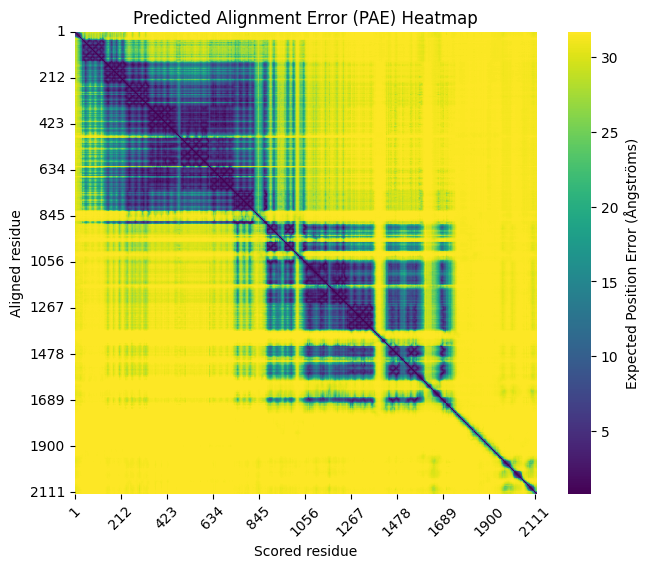

In [7]:
#@title # **Predicted Alignment Error (PAE) Heatmap 🔥**
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import string
from IPython.display import Markdown

# ---Prepare Data---
# Function to load JSON data from a file
def extract_data(json_file_path):
    try:
        # Open the JSON file and load the data
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        return data

    except Exception as e:
        print("Error reading the JSON file:", e)

# Function to calculate chain lengths
def calculate_chain_lengths(token_res_ids):
    chain_lengths = []
    current_chain_length = 1  # Initialize with 1 to account for the first residue
    previous_residue = token_res_ids[0]

    for residue in token_res_ids[1:]:
        if residue == previous_residue + 1:
            current_chain_length += 1
        else:
            chain_lengths.append(current_chain_length)
            current_chain_length = 1
        previous_residue = residue

    # Add length of the last chain
    chain_lengths.append(current_chain_length)

    return chain_lengths

# Put the data into arrays
data = extract_data(selected_full_data_file_path)
pae_data = data['pae']
token_res_ids = data['token_res_ids']

display(Markdown('**File path:**'))
print(selected_full_data_file_path)
print()
print('Number of residues: {}'.format(len(token_res_ids)))

# Calculate entity lengths
chain_lengths = calculate_chain_lengths(token_res_ids)
print('Entity lengths:', chain_lengths)

# Calculate total number of residues
total_residues = sum(chain_lengths)

# Create heatmap
plt.figure(figsize=(8, 6))

# Plot the heatmap for the entire data
pae_heatmap = sns.heatmap(pae_data, cmap='viridis', cbar_kws={'label': 'Expected Position Error (Ångströms)'}, square=True)

# Customize plot
plt.title('Predicted Alignment Error (PAE) Heatmap')
plt.xlabel('Scored residue')
plt.ylabel('Aligned residue')

# Set tick positions to cover the full range of data
tick_positions = np.arange(total_residues)
tick_labels = [str(i+1) for i in range(total_residues)]  # Adjust for 1-based indexing

# Adjust tick frequency
num_ticks = 10  # Change this value to adjust the number of ticks
tick_step = total_residues // num_ticks
if tick_step == 0:  # Ensure at least one tick per interval
    tick_step = 1
plt.xticks(tick_positions[::tick_step], tick_labels[::tick_step], rotation=45)
plt.yticks(tick_positions[::tick_step], tick_labels[::tick_step])

# Show color legend
cbar = pae_heatmap.collections[0].colorbar
cbar.set_label('Expected Position Error (Ångströms)')

# Show the plot
plt.show()

pae_heatmap_image = pae_heatmap.get_figure()

# Store which folder was used when creating the figure
pae_heatmap_folder = selected_folder_path

**File path:**

/content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /akap240_fap65_seed-1_sample-full_data_0.json

Number of residues: 2118
Entity Lengths: [2118]


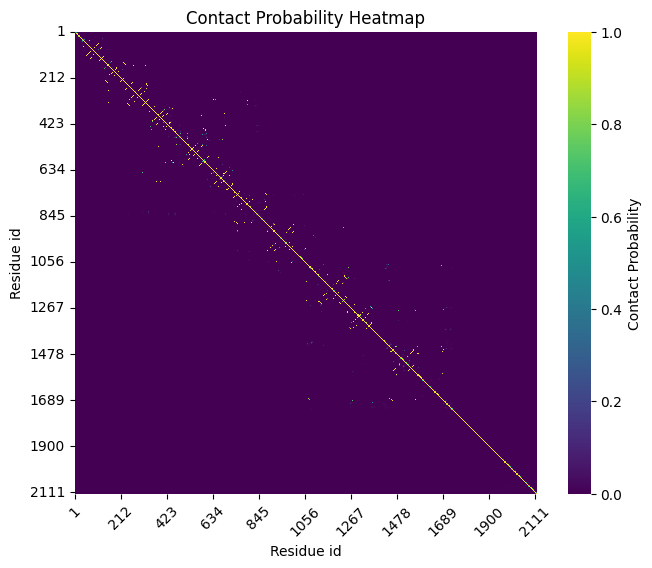

In [8]:
#@title # **Contact Probability Heatmap ↔**
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import string
from IPython.display import Markdown

# ---Prepare Data---
# Function to load JSON data from a file
def extract_data(json_file_path):
    try:
        # Open the JSON file and load the data
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        return data

    except Exception as e:
        print("Error reading the JSON file:", e)

# Function to calculate chain lengths
def calculate_chain_lengths(token_res_ids):
    chain_lengths = []
    current_chain_length = 1  # Initialize with 1 to account for the first residue
    previous_residue = token_res_ids[0]

    for residue in token_res_ids[1:]:
        if residue == previous_residue + 1:
            current_chain_length += 1
        else:
            chain_lengths.append(current_chain_length)
            current_chain_length = 1
        previous_residue = residue

    # Add length of the last chain
    chain_lengths.append(current_chain_length)

    return chain_lengths

# Put the data into arrays
data = extract_data(selected_full_data_file_path)
contact_data = data['contact_probs']
token_res_ids = data['token_res_ids']

display(Markdown('**File path:**'))
print(selected_full_data_file_path)
print()
print('Number of residues: {}'.format(len(token_res_ids)))

# Calculate chain lengths
chain_lengths = calculate_chain_lengths(token_res_ids)
print('Entity Lengths:', chain_lengths)

# Calculate total number of residues
total_residues = sum(chain_lengths)

# Create heatmap
plt.figure(figsize=(8, 6))

# Plot the heatmap for the entire data
contact_probs_heatmap = sns.heatmap(contact_data, cmap='viridis', cbar_kws={'label': 'PAE'}, square=True)

# Customize plot
plt.title('Contact Probability Heatmap')
plt.xlabel('Residue id')
plt.ylabel('Residue id')

# Set tick positions to cover the full range of data
tick_positions = np.arange(total_residues)
tick_labels = [str(i+1) for i in range(total_residues)]  # Adjust for 1-based indexing

# Adjust tick frequency
num_ticks = 10  # Change this value to adjust the number of ticks
tick_step = total_residues // num_ticks
if tick_step == 0:  # Ensure at least one tick per interval
    tick_step = 1
plt.xticks(tick_positions[::tick_step], tick_labels[::tick_step], rotation=45)
plt.yticks(tick_positions[::tick_step], tick_labels[::tick_step])

# Show color legend
cbar = contact_probs_heatmap.collections[0].colorbar
cbar.set_label('Contact Probability')

# Show the plot
plt.show()

contact_probs_heatmap_image = contact_probs_heatmap.get_figure()

# Store which folder was used when creating the figure
contact_probs_heatmap_folder = selected_folder_path

In [11]:
#@title # **Save Analysis Heatmaps 💾**
import os

if selected_folder_path:
  folder_prefix = selected_folder_path.split('/')[-1]
if iptm_matrix_heatmap_image is not None and selected_integer_ending is not None and iptm_matrix_heatmap_folder == selected_folder_path:
  path = os.path.join(selected_folder_path, folder_prefix + "_iptm_matrix_heatmap_" + selected_integer_ending + ".png")
  iptm_matrix_heatmap_image.savefig(path)
  print('Saved ipTM matrix heatmap at ' + path)
if pae_heatmap_image is not None and selected_integer_ending is not None and pae_heatmap_folder == selected_folder_path:
  path = os.path.join(selected_folder_path, folder_prefix + "_pae_heatmap_" + selected_integer_ending + ".png")
  pae_heatmap_image.savefig(path)
  print('Saved pae heatmap at ' + path)
if contact_probs_heatmap_image is not None and selected_integer_ending is not None and contact_probs_heatmap_folder == selected_folder_path:
  path = os.path.join(selected_folder_path, folder_prefix + "_contact_probs_heatmap_" + selected_integer_ending + ".png")
  contact_probs_heatmap_image.savefig(path)
  print('Saved contact probability heatmap at ' + path)


Saved pae heatmap at /content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /AKAP240 _pae_heatmap_0.png
Saved contact probability heatmap at /content/drive/MyDrive/LAB DATA/X sem/af3/AKAP240 /AKAP240 _contact_probs_heatmap_0.png


**Note:** Run the cell ▶ to save 💾 the heatmap images in the folder you have specified at the top. You will get a notification for each file that was saved at the bottom of the cell. When you change the output folder at top, only the images from the cells you have run with the current folder are saved.